In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import lightning as pl
import datasets
import numpy as np
import math
from einops import rearrange, repeat

pl.seed_everything(89026614)

text = datasets.load_dataset('tiny_shakespeare')["train"][0]["text"]
#text = open('../../Downloads/simplebooks/simplebooks-2-raw/train.txt', 'r').read()

/Users/cztomsik/miniconda3/envs/torch-mps/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 89026614
Found cached dataset tiny_shakespeare (/Users/cztomsik/.cache/huggingface/datasets/tiny_shakespeare/default/1.0.0/b5b13969f09fe8707337f6cb296314fbe06960bd9a868dca39e713e163d27b5e)
100%|██████████| 3/3 [00:00<00:00, 1126.09it/s]


In [2]:
device = "mps"
block_size = 256
test_size = 1500
batch_size = 36

class MyDataset(data.Dataset):
    def __init__(self, text):
        super().__init__()
        vocab = sorted(set(text))
        self.vocab = vocab
        self.stoi = { ch: i for i, ch in enumerate(vocab) }
        self.itos = { i: ch for i, ch in enumerate(vocab) }
        self.data = torch.tensor([self.stoi[ch] for ch in text], dtype=torch.long)

    def __len__(self):
        return self.data.size(0) - block_size - 1

    def __getitem__(self, i):
        end = i + block_size
        return self.data[i:end], self.data[i + 1:end + 1]

dataset = MyDataset(text)
train = data.Subset(dataset, range(0, len(dataset) - test_size))
test = data.Subset(dataset, range(len(dataset) - test_size, len(dataset)))

In [3]:
class GPT(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, num_layers=4):
        super().__init__()
        self.transformer = nn.Sequential(
            nn.Embedding(vocab_size, embed_dim),
            nn.Sequential(*[Layer(embed_dim) for _ in range(num_layers)]),
            nn.LayerNorm(embed_dim),
        )
        self.lm_head = nn.Linear(embed_dim, vocab_size, bias=False)
    
    def forward(self, x):
        return self.lm_head(self.transformer(x))

class Layer(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_dim)
        self.f = nn.Linear(embed_dim, embed_dim, bias=False)
        self.q = nn.Linear(embed_dim, embed_dim, bias=False)
        self.v = nn.Linear(embed_dim, embed_dim, bias=False)
        self.proj = nn.Linear(embed_dim, embed_dim, bias=False)
        self.ln2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            nn.GELU(approximate="tanh"),
            nn.Linear(4 * embed_dim, embed_dim),
        )
        self.proj = nn.Linear(embed_dim, embed_dim, bias=False)

    def forward(self, x):
        B, T, C = x.shape
        xn = self.ln1(x)
        prev = F.pad(xn, (0, 0, 1, -1))
        prev2 = F.pad(xn, (0, 0, 2, -2))
        f = torch.sigmoid(self.f(prev)) # prev can say what should be forgotten from prev2 (x-2)
        q = torch.sigmoid(self.q(xn)) # what should be accepted from prev
        v = self.v(prev) # what the prev is providing
        attn = self.proj((q * v) - (f * self.v(prev2)))

        x = x + attn
        x = x + self.mlp(self.ln2(x))
        return x

class Model(pl.LightningModule):
    def __init__(self, vocab_size, lr=0.007):
        super().__init__()
        self.lr = lr
        self.model = GPT(vocab_size)
    
    def forward(self, x, y=None):
        logits = self.model(x)
        return logits if y is None else F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), ignore_index=-1)

    def train_dataloader(self):
        return data.DataLoader(train, batch_size=batch_size, num_workers=0, sampler=data.RandomSampler(train, False, 6_000))

    def training_step(self, batch, batch_idx):
        return self(*batch)

    def val_dataloader(self):
        return data.DataLoader(test, batch_size=batch_size, num_workers=0)
    
    def validation_step(self, batch, batch_idx):
        loss = self(*batch)
        self.log("test_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_epoch_end(self, outs):
        with torch.no_grad():
            print(self.generate("And now", 64))

    def configure_optimizers(self):
        optim = torch.optim.Adam(self.parameters(), lr=self.lr)
        sched = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.95, last_epoch=-1)
        return [optim], [sched]

    # inspired by https://github.com/karpathy/minGPT/blob/master/mingpt/model.py
    @torch.no_grad()
    def generate(self, str, max_new_tokens, top_k=10):
        ids = torch.tensor([dataset.stoi[ch] for ch in str], dtype=torch.long).unsqueeze(0).to(self.device)
        for _ in range(max_new_tokens):
            out = self(ids[:, -block_size:])
            logits = out[:, -1, :]
            v, _ = torch.topk(logits, top_k)
            logits[logits < v[:, [-1]]] = -float("Inf")
            step_res = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1)
            # auto-regression
            ids = torch.cat((ids, step_res), dim=1)
        return "".join([dataset.itos[int(i)] for i in ids[0]])

model = Model(len(dataset.vocab))
trainer = pl.Trainer(max_epochs=25, enable_progress_bar=True, accelerator="gpu" if device == "cuda" else device)
trainer.fit(model)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/cztomsik/miniconda3/envs/torch-mps/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(

  | Name  | Type | Params
-------------------------------
0 | model | GPT  | 207 K 
-------------------------------
207 K     Trainable params
0         Non-trainable params
207 K     Total params
0.829     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/cztomsik/miniconda3/envs/torch-mps/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 24.57it/s]And nowvHB'YvBACDK'hvs?RJKYkD3 ReNtLFWtDKA:3D3OX, VEWtLKqQHo;eD:sQfUuxt
                                                                           

/Users/cztomsik/miniconda3/envs/torch-mps/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 209/209 [00:06<00:00, 30.81it/s, loss=1.6, v_num=82] And now were a sovers
In the watch hear name time the canive well not t
Epoch 1: 100%|██████████| 209/209 [00:06<00:00, 32.81it/s, loss=1.47, v_num=82, test_loss=1.770]And now! my lord,
For thou stull
that missage
Hath full.

KING RICHGRRI
Epoch 2: 100%|██████████| 209/209 [00:06<00:00, 33.52it/s, loss=1.4, v_num=82, test_loss=1.580] And now.
Who can the people their lords, there is news must he imputy, 
Epoch 3: 100%|██████████| 209/209 [00:06<00:00, 33.63it/s, loss=1.38, v_num=82, test_loss=1.510]And now;
I prove a people thy drembles an a gracious lord, but since th
Epoch 4: 100%|██████████| 209/209 [00:06<00:00, 33.80it/s, loss=1.35, v_num=82, test_loss=1.480]And now more the day,
Shall wears here.

HASTINGS:
Ay, as the prince in
Epoch 5: 100%|██████████| 209/209 [00:06<00:00, 32.81it/s, loss=1.34, v_num=82, test_loss=1.440]And now there how: and say.
Came itseen the mistome short to you.

KING
Epoch 7: 

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 209/209 [00:09<00:00, 22.18it/s, loss=1.2, v_num=82, test_loss=1.400]


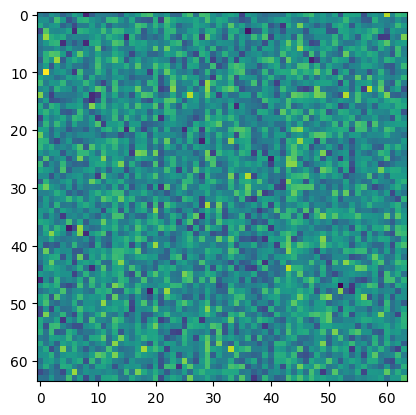

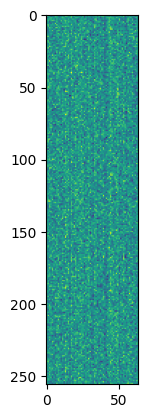

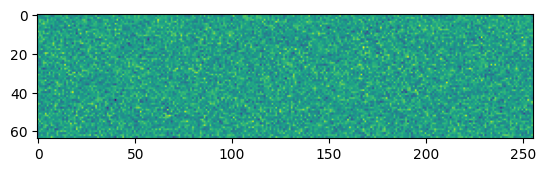

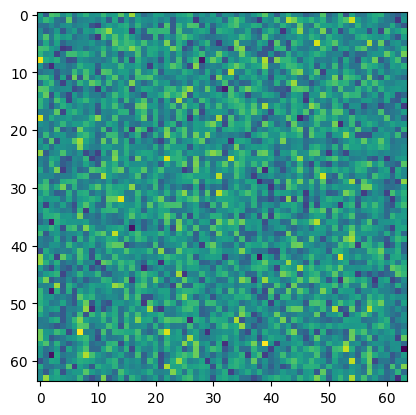

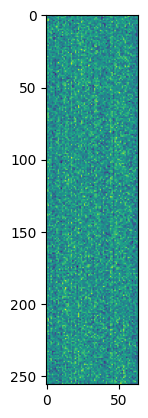

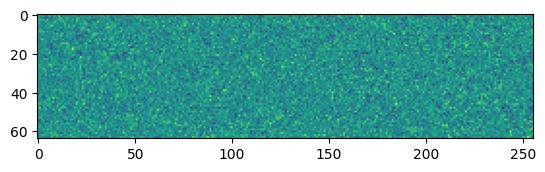

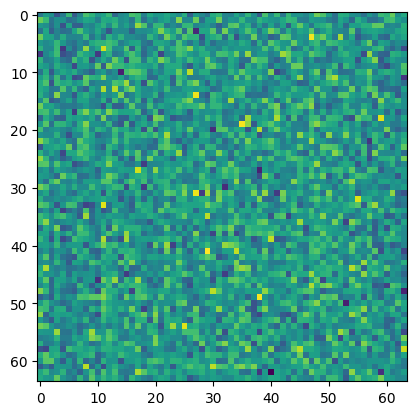

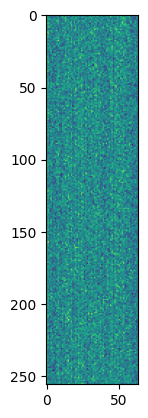

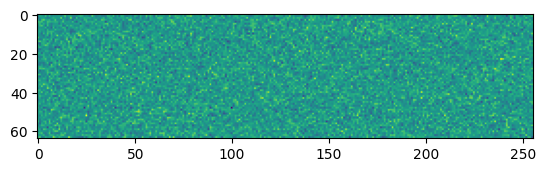

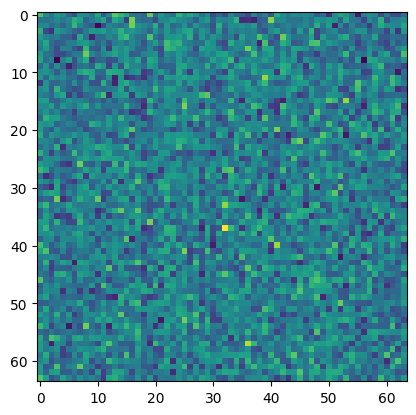

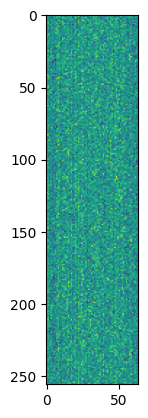

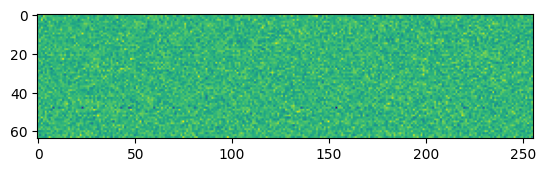

In [4]:
from matplotlib import pyplot as plt
for b in model.model.transformer[1]:
    plt.figure()
    plt.imshow(b.q.weight.detach())
    plt.figure()
    plt.imshow(b.mlp[0].weight.detach())
    plt.figure()
    plt.imshow(b.mlp[2].weight.detach())

In [5]:
print(model.generate("O God, O God!".rjust(block_size), 650))

                                                                                                                                                                                                                                                   O God, O God!

First Senator:
If you like.

First Hunger than your family! mark the worst of dark;
I came infrink, madam, farewell.

DUCHESS OF YORK:
My dearest of his people to his heart the time?
What still, I have such perfection, the most breathe forest bid him so breathize some hurt as none miles of damned at the harms and famous and play.
A begging of ill.

MARCIUS:
'Tyition:
Truly son
He had shed and down, and not so, because
He does arriving my princely good friends against the glorious prince you have not stir seem into
Supply she shall show your gentleman:
It more perfect the princely good as his face?

First Murderer:
I do proved him, with an o
